# BIM Production

In [1]:
# Import Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/mobook/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

We consider Caroline's material planning again, but now with more sophisticated pricing and acquisition protocols. 
There are now three suppliers. 
The suppliers can deliver the following materials:
 - A: **silicon**, **germanium** and **plastic**
 - B: **copper**
 - C: all of the above
Copper should be acquired in multiples of 100 gram, since it is delivered in sheets of 100 gram. 
Unitary materials such as silicon, germanium and plastic may be acquired in any number, but the price is in batches of 100. Meaning that 30 units of silicon with 10 units of germanium and 50 units of plastic cost as much as 1 unit of silicon but half as much as 30 units of silicon with 30 units of germanium and 50 units of plastic. 
Furthermore, supplier C sells all materials and offers a discount if purchased together: 100 gram of copper and a batch of unitary material cost just 7. This set price is only applied to pairs, meaning that 100 gram of copper and 2 batches cost 13.

The prices are as follows in &euro;:

|Supplier|Copper per sheet of 100 gram|Batch of units|Together|
|:-------|---------------------:|-----------------:|-------:|
| A      |                    - |                5 |      - |
| B      |                    3 |                - |      - |
| C      |                    4 |                6 |      7 |

When stocking materials, the inventory costs are as follows per month:

|Copper per 10 gram| Silicon per unit| Germanium per unit|Plastic per unit|
|---:|-------:|---:|-----:|
| 0.1|   0.02 |0.02| 0.02 |

The holding price of copper is per 10 gram and the copper stocked is rounded up to multiples of 10 grams, meaning that 12 grams pay for 20. 

The capacity limitations of the warehouse allow for a maximum of 10 kilogram of copper in stock at any moment.
There are no practical limitations to the number of units in stock.

As you recall, Caroline has the following stock at the moment:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 480|   1000 |1500| 1750 |

Caroline would like to have at least the following stock at the end of the year:

|Copper |Silicon |Germanium |Plastic|
|---:|-------:|---:|-----:|
| 200|    500 | 500| 1000 |

Please help her to model the material planning and solve it with the data above. 
Note that Caroline aims at minimizing the acquisition and holding costs of the materials while meeting the required quantities for production. 
The production is made to order, meaning that no inventory of chips is kept.


To be self contained... alternative is to upload and read a file. 

In [2]:
import pandas as pd
from io import StringIO

demand_data = '''
chip,  Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec
Logic,  88, 125, 260, 217, 238, 286, 248, 238, 265, 293, 259, 244
Memory, 47,  62,  81,  65,  95, 118,  86,  89,  82,  82,  84,  66
'''

demand_chips = pd.read_csv(StringIO(demand_data), index_col='chip')
display(demand_chips)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
chip,,,,,,,,,,,,
Logic,88,125,260,217,238,286,248,238,265,293,259,244
Memory,47,62,81,65,95,118,86,89,82,82,84,66


In [3]:
use = pd.DataFrame({
    'Logic': {'silicon': 1, 'plastic': 1, 'copper': 4},
    'Memory': {'germanium': 1, 'plastic': 1, 'copper': 2}
}).fillna(0).astype(int)
display(use)

,Logic,Memory
silicon,1,0
plastic,1,1
copper,4,2
germanium,0,1


In [4]:
demand = use.dot(demand_chips)
display(demand)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,88,125,260,217,238,286,248,238,265,293,259,244
plastic,135,187,341,282,333,404,334,327,347,375,343,310
copper,446,624,1202,998,1142,1380,1164,1130,1224,1336,1204,1108
germanium,47,62,81,65,95,118,86,89,82,82,84,66


## DONE
 - the example has been changed to follow the BIM story
 - checked that it solves
 
## TODO: 
 - still need to describe the modeling choices.
 - still need to adjust the code to meet the style guide

In [5]:
import pyomo.environ as pyo

m = pyo.ConcreteModel("Francis' material planning")  

m.periods = demand.keys()
m.materials = demand.index

m.existing = {'silicon' : 1000, 'germanium': 1500, 'plastic': 1750, 'copper' : 4800}
m.desired  = {'silicon' :  500, 'germanium':  500, 'plastic': 1000, 'copper' : 2000}

m.suppliers = pyo.Set(initialize=['A','B','C'])
m.supplyingPoles = pyo.Set(initialize=['B', 'C'])
m.supplyingBatches = pyo.Set(initialize=['A', 'C'])
m.givingDiscount = pyo.Set(initialize=['C'])

# we express prices in cents to preserve integers
m.priceBatch = {'A': 500, 'C': 600}
m.pricePole  = {'B': 300, 'C': 400}
m.discount   = m.priceBatch['C'] + m.pricePole['C'] - 700

m.batchSize = 100

m.unitaryHoldingCosts = { 'copper': 10, 'silicon' : 2, 'germanium': 2, 'plastic': 2 }
m.unitaryMaterials = [ 'silicon', 'germanium', 'plastic' ]

m.stock     = pyo.Var(m.materials, m.periods, domain=pyo.NonNegativeReals)
m.buy       = pyo.Var(m.supplyingBatches, m.unitaryMaterials, m.periods, domain=pyo.NonNegativeReals)
m.batches   = pyo.Var(m.supplyingBatches, m.periods, domain=pyo.NonNegativeIntegers)
m.poles     = pyo.Var(m.supplyingPoles, m.periods, domain=pyo.NonNegativeIntegers)
m.pairs     = pyo.Var(m.periods, domain=pyo.NonNegativeIntegers)
m.meters    = pyo.Var(m.periods, domain=pyo.NonNegativeIntegers)

@m.Objective(sense=pyo.minimize)
def obj(m):
    return sum(m.priceBatch[b] * m.batches[b,i] for b in m.supplyingBatches for i in m.periods) \
         + sum(m.pricePole[p] * m.poles[p,i] for p in m.supplyingPoles for i in m.periods) \
         - sum(m.discount * m.pairs[i] for i in m.periods) \
         + sum(m.unitaryHoldingCosts['copper'] * m.meters[i] for i in m.periods)  \
         + sum(m.unitaryHoldingCosts[j] * m.stock[j,i] for j in m.unitaryMaterials for i in m.periods) 

@m.Constraint(m.periods)
def pairsInBatches(m, i):
    return m.pairs[i] <= m.batches['C', i]
    
@m.Constraint(m.periods)
def pairsInPoles(m, i):
    return m.pairs[i] <= m.poles['C', i]

@m.Constraint(m.periods)
def woodStock(m, i):
    return m.stock['copper', i] <= 10 * m.meters[i]

@m.Constraint(m.periods)
def woodStockMax(m, i):
    return m.stock['copper', i] <= 10000

@m.Constraint(m.periods, m.supplyingBatches)
def inBatches(m, i, b):
    return sum(m.buy[b, j, i] for j in m.unitaryMaterials) <= m.batchSize * m.batches[b, i]

first = m.periods[0]
last  = m.periods[-1]

@m.Constraint(m.unitaryMaterials)
def stock_first(m, j):
    return m.stock[j, first] == m.existing[j] + sum(m.buy[b, j, first] for b in m.supplyingBatches) - demand.loc[j, first]

@m.Constraint(m.unitaryMaterials)
def stock_last(m, j):
    return m.stock[j, last] >= m.desired[j]

@m.Constraint()
def copper_first(m):
    return m.stock['copper', first] == m.existing['copper'] + 100*sum(m.poles[p,first] for p in m.supplyingPoles) - demand.loc['copper', first]

@m.Constraint()
def copper_last(m):
    return m.stock['copper', last] >= m.desired['copper']

m.constraints = pyo.ConstraintList()  # Create a set of constraints

for j in m.unitaryMaterials:
    for prev, current in zip(m.periods, m.periods[1:]):
        m.constraints.add( m.stock[j,current] == m.stock[j,prev] + sum(m.buy[b,j,current] for b in m.supplyingBatches) - demand.loc[j,current] )

for prev, current in zip(m.periods, m.periods[1:]):
    m.constraints.add( m.stock['copper',current] == m.stock['copper',prev] + 100*sum(m.poles[p,current] for p in m.supplyingPoles) - demand.loc['copper',current] )

results = pyo.SolverFactory('cbc').solve(m)
results.write()


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: unknown
  Lower bound: 110216.0
  Upper bound: 110216.0
  Number of objectives: 1
  Number of constraints: 86
  Number of variables: 170
  Number of binary variables: 0
  Number of integer variables: 72
  Number of nonzeros: 130
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  User time: -1.0
  System time: 12.41
  Wallclock time: 12.99
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Statistics: 
    Branch 

In [6]:
if  results.solver.termination_condition == 'optimal':
    import numpy as np
    np.set_printoptions(edgeitems=3,infstr='inf',linewidth=200, nanstr='nan', precision=15, suppress=False, threshold=1000, formatter=None)
    value   = m.obj.expr()
    Batches = [ [ m.batches[b,i].value for i in m.periods ] for b in m.supplyingBatches ]
    Poles   = [ [ m.poles[b,i].value for i in m.periods ] for b in m.supplyingPoles ]
    Pairs   = [ m.pairs[i].value for i in m.periods ] 
    Buy     = [ [ [ m.buy[s,j,i].value for i in m.periods ] for j in m.unitaryMaterials ] for s in m.supplyingBatches ]
    Stock   = [ [ m.stock[j,i].value for i in m.periods ] for j in m.materials ]
    Meters  = [ m.meters[i].value for i in m.periods ]
    
    def months( before='', after='', length=5 ):
        return ''.join( ['{:>{l}s}'.format(before,l=length)] + [ '{:>{l}s}'.format(j,l=length) for j in calendar.month_abbr[1:] + ['{:>{l}s}'.format(after,l=length)] ] )
        
    def describe( list, decimals=0 ):
        formattedList = [ '{:5.{prec}f}'.format( member + 0, prec=decimals ) for member in list]
        return ''.join(formattedList)
        
    print('')
    print( 'Costs : ', np.around( value/100, 3 ) )
    print('')
    print( '{:>13s}'.format('periods') + ''.join( [ '{:>{l}s}'.format(p,l=5) for p in m.periods ] ) )
    
    print( 'buy')
    for s,supplier in enumerate(m.supplyingBatches):
        print(supplier)
        for i,j in enumerate(m.unitaryMaterials):
            print('{:>13s}'.format(j) + describe( Buy[s][i] ) )
    print( 'batches')
    for s,supplier in enumerate(m.supplyingBatches):
        print('{:>13s}'.format(supplier) + describe( Batches[s] ) )
    print( 'poles' )
    for s,supplier in enumerate(m.supplyingPoles):
        print('{:>13s}'.format(supplier) + describe( Poles[s] ) )
        
    print( '' )
    print('{:>13s}'.format('pairs from C') + describe( Pairs ) )
    print( '' )
            
    import calendar 
    print( 'stock')
    print( '{:>12s}'.format('material') + months( before='from', after='to') )
    for i,j in enumerate(m.materials):
        print( '{:>12s}'.format(j) + describe( [m.existing[j]] + Stock[i] + [m.desired[j]] ) )
       
    print( '' )
    print('{:>17s}'.format('full copper meters') + describe( Meters ) )


Costs :  1102.16

      periods  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep  Oct  Nov  Dec
buy
A
      silicon    0    0    0    0    0    0    0    0    0    0    0    0
    germanium    0    0    0    0    0    0    0    0    0    0    0    0
      plastic    0    0    0    0    0    0    0    0    0    0    0    0
C
      silicon    0    0    0    0    0  229  233  238  265  349  257  690
    germanium    0    0    0    0    0    0    0    0    0    0    0    0
      plastic    0    0    0    0    0    0  267  362  335  351  343 1310
batches
            A    0    0    0    0    0    0    0    0    0    0    0    0
            C    0    0    0    0    0    3    5    6    6    7    6   20
poles
            B    0    0    0    0    0    7    7    5    7    6    6   11
            C    0    0    0    0    0    3    5    6    6    7    6   20

 pairs from C    0    0    0    0    0    3    5    6    6    7    6   20

stock
    material from  Jan  Feb  Mar  Apr  May  Jun  Jul  Aug  Sep 

## Tabular variables are ideal for dataframes

In [7]:
def ShowTriple(X, I, J, K, names):
    index = pd.MultiIndex.from_product([I,J], names=names)
    return pd.DataFrame.from_records( [ [ X[i,j,k].value for k in K ] for i in I for j in J ],index=index,columns=K )

def ShowDouble( X, I,J ):
    return pd.DataFrame.from_records( [ [ X[i,j].value for j in J ] for i in I ], index=I, columns=J )

def ShowSingle(X, I):
    return pd.DataFrame([X[i].value for i in I], index=I).T

In [8]:
ShowTriple(m.buy, m.supplyingBatches, m.unitaryMaterials, m.periods, ['supplier', 'materials']).astype(int)

Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep  \
supplier materials                                                          
A        silicon        0     0     0     0     0     0     0     0     0   
         germanium      0     0     0     0     0     0     0     0     0   
         plastic        0     0     0     0     0     0     0     0     0   
C        silicon        0     0     0     0     0   229   233   238   265   
         germanium      0     0     0     0     0     0     0     0     0   
         plastic        0     0     0     0     0     0   267   362   335   

                     Oct   Nov   Dec  
supplier materials                    
A        silicon       0     0     0  
         germanium     0     0     0  
         plastic       0     0     0  
C        silicon     349   257   690  
         germanium     0     0     0  
         plastic     351   343  1310

In [9]:
ShowDouble( m.stock, m.materials, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
silicon,912,787,527,310,72,15,0,0,0,56,54,500
plastic,1615,1428,1087,805,472,68,1,36,24,0,0,1000
copper,4354,3730,2528,1530,388,8,44,14,90,54,50,2042
germanium,1453,1391,1310,1245,1150,1032,946,857,775,693,609,543


In [10]:
ShowDouble( m.batches, m.supplyingBatches, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
A,0,0,0,0,0,0,0,0,0,0,0,0
C,0,0,0,0,0,3,5,6,6,7,6,20


In [11]:
ShowDouble( m.poles, m.supplyingPoles, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
B,0,0,0,0,0,7,7,5,7,6,6,11
C,0,0,0,0,0,3,5,6,6,7,6,20


In [12]:
ShowSingle( m.pairs, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,0,0,0,0,0,3,5,6,6,7,6,20


In [13]:
ShowSingle( m.meters, m.periods ).astype(int)

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,436,373,253,153,39,1,5,2,9,6,5,205


## Dataframes come with a wealth of ready made graphics

In [14]:
stock = ShowDouble( m.stock, m.materials, m.periods ).astype(int).T
%matplotlib inline
import matplotlib.pyplot as plt

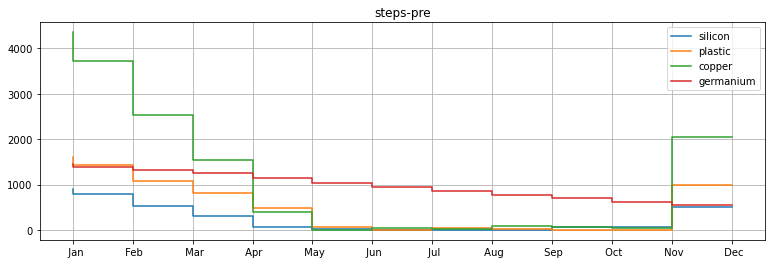

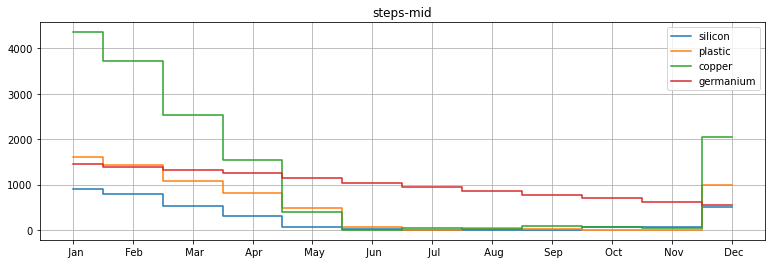

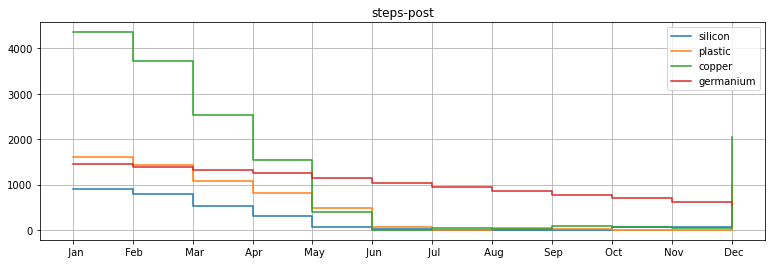

In [15]:
steps = ['pre','mid','post']
for s in steps:
  step = 'steps-'+s
  ax = stock.plot(drawstyle=step,grid=True, figsize=(13,4), title=step)
  ax.set_xticks(range(len(stock.index)))
  ax.set_xticklabels(stock.index)
  plt.show()

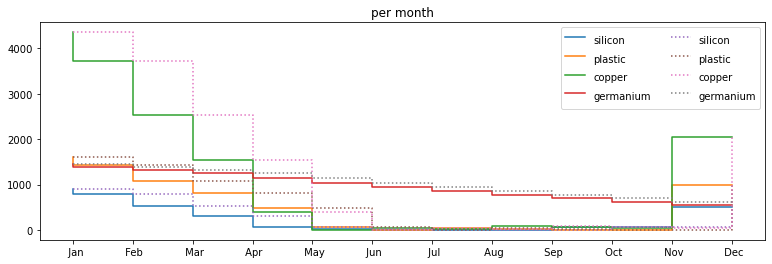

In [16]:
ax = stock.plot(drawstyle='steps-'+steps[0],figsize=(13,4), title='per month')
ax.set_xticks(range(len(stock.index)))
ax.set_xticklabels(stock.index)
for s in steps[-1:]:
  step = 'steps-'+s
  stock.plot(ax=ax,drawstyle=step, ls=':')
plt.legend(ncol=2,handleheight=2.4, labelspacing=0.05)
plt.show()